## Reference 

1. MMDetection Inspired Notebooks:
    1. https://www.kaggle.com/awsaf49/sartorius-mmdetection-train
    1. https://www.kaggle.com/its7171/mmdetection-for-segmentation-training
    1. https://www.kaggle.com/vexxingbanana/sartorius-mmdetection-training
    1. https://www.kaggle.com/remekkinas/yolox-training-pipeline-cots-dataset-lb-0-507
    1. https://www.kaggle.com/superkevingit/faster-rcnn-with-mmdetection-without-internet
    1. 
1. Yolox COCO Dataset : [Efficient Coco datasest generator](https://www.kaggle.com/coldfir3/simple-yolox-dataset-generator-coco-json)
1. Torch Dataset
    1. https://www.kaggle.com/ttjccc/pytorch-190

# LOGS
1. [Inference Notebook](https://www.kaggle.com/mlneo07/mmdetection-swin-transfomer-frcnn-inference)
1. Minor Bugs Fixes
1. Changed Tiny --> Small transformer
1. New loss_bbox=dict(type='GIoULoss', loss_weight=10.0)))) ; IoULoss --> GIoULoss
1. FasterRCNN -- > CascadeRCNN
1.    
    train_cfg=dict(
        rpn=dict(sampler=dict(neg_pos_ub=5), allowed_border=-1),
        rcnn=dict(
            sampler=dict(
                _delete_=True,
                type='CombinedSampler',
                num=512,
                pos_fraction=0.25,
                add_gt_as_proposals=True,
                pos_sampler=dict(type='InstanceBalancedPosSampler'),
                neg_sampler=dict(
                    type='IoUBalancedNegSampler',
                    floor_thr=-1,
                    floor_fraction=0,
                    num_bins=3)))))

# **Install MMDetection and MMDetection-Compatible Torch**

In [1]:
!pip install '../input/pytorch-190/torch-1.9.0+cu111-cp37-cp37m-linux_x86_64.whl' --no-deps
# !pip install '../input/pytorch-190/torchvision-0.10.0+cu111-cp37-cp37m-linux_x86_64.whl' --no-deps

Processing /kaggle/input/pytorch-190/torch-1.9.0+cu111-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1


In [2]:
!git clone https://github.com/open-mmlab/mmdetection.git /kaggle/working/mmdetection

Cloning into '/kaggle/working/mmdetection'...
remote: Enumerating objects: 22956, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 22956 (delta 0), reused 0 (delta 0), pack-reused 22954
Receiving objects: 100% (22956/22956), 25.74 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (16085/16085), done.


In [3]:
!pip install openmim
!mim install mmdet
!pip install wandb --upgrade

  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 82 kB 425 kB/s            
  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42502 sha256=90d4bc025645f31daaa1e45934079288fb84807cef6aa079d66e32b445770c38
  Stored in directory: /root/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
Successfully built openmim
  Attempting uninstall: Click
    Found existing installation: click 8.0.3
    Uninstalling click-8.0.3:
      Successfully uninstalled click-8.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2021.11.2 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2021.11.2 which is incompatible.
instal

# **Import Libraries** 

In [4]:
# import sys
# sys.path.append('./mmdetection')


import os
import random
import numpy as np
import pandas as pd
import torch, torchvision
from pathlib import Path

import mmdet
import mmcv

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.apis import set_random_seed
from mmcv import Config
from mmdet.apis import inference_detector, init_detector, set_random_seed

# Setup W&B

To connect the Kaggle Notebook and log in to Weights & Biases, we need to create an API key:

1. New users can sign up for a Free Weights & Biases account for Research and Personal use from the https://wandb.ai/site page. Sign up process takes around 1-2 minutes.
2. Now get the API key from https://wandb.ai/authorize.

Login to Weights & Biases from the notebook with the API key by using any of the two methods below:

* Interative:
    1. Run a cell with wandb.login(). It will ask for the API key, which can be copied and pasted to authenticate.

* Kaggle Secrets:
    1. The recommended way to use the API key is to use Kaggle Secrets to store the API key. From the top Menu on the Notebook Editor, click on 'Add-ons' and then, select 'Secrets'.
    2. Select 'Add a new secret' and provide 'wandb_key' for label and it's value as the API key obtained from the previous steps.

In [5]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_api" as Label. 
# If you use some other Label make sure to change the same below. 
wandb_api = user_secrets.get_secret("wandb_key") 

wandb.login(key=wandb_api)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# **Helper Functions**

In [6]:
%%writefile labels.txt 
cots

Writing labels.txt


In [7]:
seed = 42

def set_seed(seed=seed):
    """Sets the random seeds."""
    set_random_seed(seed, deterministic=False)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

## Model settings

In [8]:
# %%writefile ./mmdetection/configs/_base_/models/cascade_rcnn_r50_fpn.py

# # model settings
# model = dict(
#     type='CascadeRCNN',
#     backbone=dict(
#         type='ResNet',
#         depth=50,
#         num_stages=4,
#         out_indices=(0, 1, 2, 3),
#         frozen_stages=1,
#         norm_cfg=dict(type='BN', requires_grad=True),
#         norm_eval=True,
#         style='pytorch',
#         init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
#     neck=dict(
#         type='FPN',
#         in_channels=[256, 512, 1024, 2048],
#         out_channels=256,
#         num_outs=5),
#     rpn_head=dict(
#         type='RPNHead',
#         in_channels=256,
#         feat_channels=256,
#         anchor_generator=dict(
#             type='AnchorGenerator',
#             scales=[8],
#             ratios=[0.5, 1.0, 2.0],
#             strides=[4, 8, 16, 32, 64]),
#         bbox_coder=dict(
#             type='DeltaXYWHBBoxCoder',
#             target_means=[.0, .0, .0, .0],
#             target_stds=[1.0, 1.0, 1.0, 1.0]),
#         loss_cls=dict(
#             type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
#         loss_bbox=dict(type='SmoothL1Loss', beta=1.0 / 9.0, loss_weight=1.0)),
#     roi_head=dict(
#         type='CascadeRoIHead',
#         num_stages=3,
#         stage_loss_weights=[1, 0.5, 0.25],
#         bbox_roi_extractor=dict(
#             type='SingleRoIExtractor',
#             roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0),
#             out_channels=256,
#             featmap_strides=[4, 8, 16, 32]),
#         bbox_head=[
#             dict(
#                 type='Shared2FCBBoxHead',
#                 in_channels=256,
#                 fc_out_channels=1024,
#                 roi_feat_size=7,
#                 num_classes=80,
#                 bbox_coder=dict(
#                     type='DeltaXYWHBBoxCoder',
#                     target_means=[0., 0., 0., 0.],
#                     target_stds=[0.1, 0.1, 0.2, 0.2]),
#                 reg_class_agnostic=True,
#                 loss_cls=dict(
#                     type='CrossEntropyLoss',
#                     use_sigmoid=False,
#                     loss_weight=1.0),
#                 loss_bbox=dict(type='SmoothL1Loss', beta=1.0,
#                                loss_weight=1.0)),
#             dict(
#                 type='Shared2FCBBoxHead',
#                 in_channels=256,
#                 fc_out_channels=1024,
#                 roi_feat_size=7,
#                 num_classes=80,
#                 bbox_coder=dict(
#                     type='DeltaXYWHBBoxCoder',
#                     target_means=[0., 0., 0., 0.],
#                     target_stds=[0.05, 0.05, 0.1, 0.1]),
#                 reg_class_agnostic=True,
#                 loss_cls=dict(
#                     type='CrossEntropyLoss',
#                     use_sigmoid=False,
#                     loss_weight=1.0),
#                 loss_bbox=dict(type='SmoothL1Loss', beta=1.0,
#                                loss_weight=1.0)),
#             dict(
#                 type='Shared2FCBBoxHead',
#                 in_channels=256,
#                 fc_out_channels=1024,
#                 roi_feat_size=7,
#                 num_classes=80,
#                 bbox_coder=dict(
#                     type='DeltaXYWHBBoxCoder',
#                     target_means=[0., 0., 0., 0.],
#                     target_stds=[0.033, 0.033, 0.067, 0.067]),
#                 reg_class_agnostic=True,
#                 loss_cls=dict(
#                     type='CrossEntropyLoss',
#                     use_sigmoid=False,
#                     loss_weight=1.0),
#                 loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=1.0))
#         ]),
#     # model training and testing settings
#     train_cfg=dict(
#         rpn=dict(
#             assigner=dict(
#                 type='MaxIoUAssigner',
#                 pos_iou_thr=0.7,
#                 neg_iou_thr=0.3,
#                 min_pos_iou=0.3,
#                 match_low_quality=True,
#                 ignore_iof_thr=-1),
#             sampler=dict(
#                 type='RandomSampler',
#                 num=256,
#                 pos_fraction=0.5,
#                 neg_pos_ub=-1,
#                 add_gt_as_proposals=False),
#             allowed_border=0,
#             pos_weight=-1,
#             debug=False),
#         rpn_proposal=dict(
#             nms_pre=2000,
#             max_per_img=2000,
#             nms=dict(type='nms', iou_threshold=0.7),
#             min_bbox_size=0),
#         rcnn=[
#             dict(
#                 assigner=dict(
#                     type='MaxIoUAssigner',
#                     pos_iou_thr=0.5,
#                     neg_iou_thr=0.5,
#                     min_pos_iou=0.5,
#                     match_low_quality=False,
#                     ignore_iof_thr=-1),
#                 sampler=dict(
#                     type='RandomSampler',
#                     num=512,
#                     pos_fraction=0.25,
#                     neg_pos_ub=-1,
#                     add_gt_as_proposals=True),
#                 pos_weight=-1,
#                 debug=False),
#             dict(
#                 assigner=dict(
#                     type='MaxIoUAssigner',
#                     pos_iou_thr=0.6,
#                     neg_iou_thr=0.6,
#                     min_pos_iou=0.6,
#                     match_low_quality=False,
#                     ignore_iof_thr=-1),
#                 sampler=dict(
#                     type='RandomSampler',
#                     num=512,
#                     pos_fraction=0.25,
#                     neg_pos_ub=-1,
#                     add_gt_as_proposals=True),
#                 pos_weight=-1,
#                 debug=False),
#             dict(
#                 assigner=dict(
#                     type='MaxIoUAssigner',
#                     pos_iou_thr=0.7,
#                     neg_iou_thr=0.7,
#                     min_pos_iou=0.7,
#                     match_low_quality=False,
#                     ignore_iof_thr=-1),
#                 sampler=dict(
#                     type='RandomSampler',
#                     num=512,
#                     pos_fraction=0.25,
#                     neg_pos_ub=-1,
#                     add_gt_as_proposals=True),
#                 pos_weight=-1,
#                 debug=False)
#         ]),
#     test_cfg=dict(
#         rpn=dict(
#             nms_pre=1000,
#             max_per_img=1000,
#             nms=dict(type='nms', iou_threshold=0.7),
#             min_bbox_size=0),
#         rcnn=dict(
#             score_thr=0.05,
#             nms=dict(type='nms', iou_threshold=0.5),
#             max_per_img=100)))

## Dataset settings

In [9]:
# %%writefile ./mmdetection/configs/_base_/datasets/coco_detection.py
  
# albu_train_transforms = [
#     dict(type='ShiftScaleRotate', shift_limit=0.0625,
#          scale_limit=0.15, rotate_limit=15, p=0.4),
#     dict(type='RandomBrightnessContrast', brightness_limit=0.2,
#          contrast_limit=0.2, p=0.5),
#     dict(type='IAAAffine', shear=(-10.0, 10.0), p=0.4),
#     dict(type="Blur", p=1.0, blur_limit=7),
#     dict(type='CLAHE', p=0.5),
#     dict(type='Equalize', mode='cv', p=0.4),
#     dict(
#         type="OneOf",
#         transforms=[
#             dict(type="GaussianBlur", p=1.0, blur_limit=7),
#             dict(type="MedianBlur", p=1.0, blur_limit=7),
#         ],
#         p=0.4,
#     ),
# #     dict(type='MixUp', p=0.2, lambd=0.5),
# #     dict(type='RandomRotate90', p=0.5),
# #     dict(type='InvertImg', p=0.5),
# #     dict(type='Equalize', mode='cv', p=0.4),
# #     dict(type='MedianBlur', blur_limit=3, p=0.1)
# ]
    
# # dataset settings
# dataset_type = 'CocoDataset'
# data_root = 'data/coco/'
# img_norm_cfg = dict(
#     mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
# train_pipeline = [
#     #     dict(
#     #         type='Albu',
#     #         transforms=albu_train_transforms,
#     #         bbox_params=dict(
#     #         type='BboxParams',
#     #         format='pascal_voc',
#     #         label_fields=['gt_labels'],
#     #         min_visibility=0.0,
#     #         filter_lost_elements=True),
#     #         keymap=dict(img='image', gt_bboxes='bboxes'),
#     #         update_pad_shape=False,
#     #         skip_img_without_anno=True),
#     dict(type='LoadImageFromFile'),
#     dict(type='LoadAnnotations', with_bbox=True),
#     dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
#     dict(type='RandomFlip', flip_ratio=0.5),
#     dict(type='Normalize', **img_norm_cfg),
#     dict(type='Pad', size_divisor=32),
#     dict(type='DefaultFormatBundle'),
#     dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
# ]
# test_pipeline = [
#     dict(type='LoadImageFromFile'),
#     dict(
#         type='MultiScaleFlipAug',
#         img_scale=(1333, 800),
#         flip=False,
#         transforms=[
#             dict(type='Resize', keep_ratio=True),
#             dict(type='RandomFlip'),
#             dict(type='Normalize', **img_norm_cfg),
#             dict(type='Pad', size_divisor=32),
#             dict(type='ImageToTensor', keys=['img']),
#             dict(type='Collect', keys=['img']),
#         ])
# ]
# data = dict(
#     samples_per_gpu=2,
#     workers_per_gpu=2,
#     train=dict(
#         type=dataset_type,
#         ann_file=data_root + 'annotations/instances_train2017.json',
#         img_prefix=data_root + 'train2017/',
#         pipeline=train_pipeline),
#     val=dict(
#         type=dataset_type,
#         ann_file=data_root + 'annotations/instances_val2017.json',
#         img_prefix=data_root + 'val2017/',
#         pipeline=test_pipeline),
#     test=dict(
#         type=dataset_type,
#         ann_file=data_root + 'annotations/instances_val2017.json',
#         img_prefix=data_root + 'val2017/',
#         pipeline=test_pipeline))
# evaluation = dict(interval=1, metric='bbox')

## Schedule settings

In [10]:
# %%writefile ./mmdetection/configs/_base_/schedules/schedule_1x.py

# # optimizer
# optimizer = dict(type='SGD', lr=0.02, momentum=0.9, weight_decay=0.0001)
# optimizer_config = dict(grad_clip=None)
# # learning policy
# lr_config = dict(
#     policy='step',
#     warmup='linear',
#     warmup_iters=500,
#     warmup_ratio=0.001,
#     step=[8, 11])
# runner = dict(type='EpochBasedRunner', max_epochs=12)

In [11]:
# cfg = Config.fromfile('./mmdetection/configs/cascade_rcnn/cascade_rcnn_r50_caffe_fpn_1x_coco.py')
# cfg = Config.fromfile('./mmdetection/configs/cascade_rcnn/cascade_rcnn_r50_fpn_1x_coco.py') 
# 20 epochs instead of 12 + lr is decreased on 16th and 19th epoch
cfg = Config.fromfile('./mmdetection/configs/cascade_rcnn/cascade_rcnn_r50_fpn_20e_coco.py')  

cfg.classes = '/kaggle/working/labels.txt'
cfg.work_dir = '/kaggle/working/model_output'
cfg.data_root = '/kaggle/working'

for head in cfg.model.roi_head.bbox_head:
    head.num_classes = 1
    
cfg.data.test.type = 'CocoDataset'
cfg.data.test.classes = 'labels.txt'
cfg.data.test.ann_file = '../input/cots-mmdet-annotations-fold-0/annotations_valid.json'
cfg.data.test.img_prefix = './val2017'

cfg.data.train.type = 'CocoDataset'
cfg.data.train.ann_file = '../input/cots-mmdet-annotations-fold-0/annotations_train.json'
cfg.data.train.img_prefix = '../input/cots-mmdet-annotations-fold-0/train2017'
cfg.data.train.classes = 'labels.txt'

cfg.data.val.type = 'CocoDataset'
cfg.data.val.ann_file = '../input/cots-mmdet-annotations-fold-0/annotations_valid.json'
cfg.data.val.img_prefix = '../input/cots-mmdet-annotations-fold-0/val2017'
cfg.data.val.classes = 'labels.txt'

cfg.data.samples_per_gpu = 8 # batch size per GPU
cfg.data.workers_per_gpu = 2

cfg.evaluation.interval = 1
cfg.evaluation.save_best='auto'
cfg.checkpoint_config.interval = 1 # The save interval is 1

cfg.seed = seed
cfg.gpu_ids = range(1)

# mixed precision training strategy, this method will theoretically reduce GPU memory comsumption by half if it has tensor cores
cfg.fp16 = dict(loss_scale=dict(init_scale=512.)) 

cfg.log_config = dict(
    interval=100,
    hooks=[
        dict(type='TextLoggerHook'),
        dict(type='TensorboardLoggerHook')
    ])

meta = dict()
meta['config'] = cfg.pretty_text

## Weights & Biases Integration for Experiment Tracking and Logging

In [12]:
fold = 0

wnb_username = 'beatwad'
wnb_project_name = 'cots'
model_name = 'cascade_rcnn_r50_fpn_1x'

# cfg.log_level = 'DEBUG'
cfg.log_config.hooks = [dict(type='TextLoggerHook'),
                        dict(type='WandbLoggerHook',
                             init_kwargs=dict(project=wnb_project_name,
                                              name=f'{model_name}-fold{fold}',
                                              entity=wnb_username))
                       ]

## Build dataset and init model

In [13]:
datasets = [build_dataset(cfg.data.train)]
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.init_weights()
model.CLASSES = datasets[0].CLASSES

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


2022-02-08 08:27:08,908 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2022-02-08 08:27:08,910 - mmcv - INFO - load model from: torchvision://resnet50
2022-02-08 08:27:08,912 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet50
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2022-02-08 08:27:13,341 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-02-08 08:27:13,383 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-02-08 08:27:13,416 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2022-02-08 08:27:13,425 - mmcv - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type': 'Xavier', 'distribution': 'uniform', 'override': [{'name': 'shared_fcs'}, {'name': 'cls_fcs'}, {'name': 'reg_fcs'}]}]
2022-02-08 08:27:13,558 - mmcv - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type': 'Xavier', 'distributio

# **Train model**

In [14]:
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True, meta=meta)

2022-02-08 08:27:19,073 - mmdet - INFO - Start running, host: root@9a15dbfc5590, work_dir: /kaggle/working/model_output
2022-02-08 08:27:19,075 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(ABOVE_NORMAL) Fp16OptimizerHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) WandbLoggerHook                    
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) WandbLoggerHook                    
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook    

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
2022-02-08 08:31:36,894 - mmdet - INFO - Epoch [1][100/347]	lr: 3.976e-03, eta: 4:45:31, time: 2.505, data_time: 0.068, memory: 7265, loss_rpn_cls: 0.2589, loss_rpn_bbox: 0.0153, s0.loss_cls: 0.1165, s0.acc: 98.3989, s0.loss_bbox: 0.0124, s1.loss_cls: 0.0550, s1.acc: 98.5022, s1.loss_bbox: 0.0047, s2.loss_cls: 0.0345, s2.acc: 91.6213, s2.loss_bbox: 0.0009, loss: 0.4982
2022-02-08 08:35:35,429 - mmdet - INFO - Epoch [1][200/347]	lr: 7.972e-03, eta: 4:34:39, time: 2.385, data_time: 0.031, memory: 7273, loss_rpn_cls: 0.1112, loss_rpn_bbox: 0.0126, s0.loss_cls: 0.1090, s0.acc: 96.8076, s0.loss

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.5 task/s, elapsed: 396s, ETA:     0s

2022-02-08 08:48:05,760 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.73s).
Accumulating evaluation results...


2022-02-08 08:48:14,556 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.390
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.52s).


2022-02-08 08:48:16,497 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_1.pth.
2022-02-08 08:48:16,498 - mmdet - INFO - Best bbox_mAP is 0.1500 at 1 epoch.
2022-02-08 08:48:16,502 - mmdet - INFO - Epoch(val) [1][2576]	bbox_mAP: 0.1500, bbox_mAP_50: 0.3900, bbox_mAP_75: 0.0710, bbox_mAP_s: 0.0180, bbox_mAP_m: 0.1870, bbox_mAP_l: 0.0840, bbox_mAP_copypaste: 0.150 0.390 0.071 0.018 0.187 0.084
2022-02-08 08:52:18,773 - mmdet - INFO - Epoch [2][100/347]	lr: 1.784e-02, eta: 3:54:45, time: 2.422, data_time: 0.071, memory: 7276, loss_rpn_cls: 0.0343, loss_rpn_bbox: 0.0102, s0.loss_cls: 0.1260, s0.acc: 95.0925, s0.loss_bbox: 0.1029, s1.loss_cls: 0.0641, s1.acc: 94.8458, s1.loss_bbox: 0.1256, s2.loss_cls: 0.0321, s2.acc: 94.0901, s2.loss_bbox: 0.0619, loss: 0.5570
2022-02-08 08:56:18,936 - mmdet - INFO - Epoch [2][200/347]	lr: 2.000e-02, eta: 3:55:40, time: 2.402, data_time: 0.042, memory: 7276, loss_rpn_cls: 0.0332, loss_rpn_bbox: 0.0104, s0.loss_cls: 0.1238, s0.acc: 95.20

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.6 task/s, elapsed: 390s, ETA:     0s

2022-02-08 09:08:44,615 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.59s).
Accumulating evaluation results...


2022-02-08 09:08:46,541 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.492
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.28s).


2022-02-08 09:08:48,526 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_2.pth.
2022-02-08 09:08:48,527 - mmdet - INFO - Best bbox_mAP is 0.1950 at 2 epoch.
2022-02-08 09:08:48,531 - mmdet - INFO - Epoch(val) [2][2576]	bbox_mAP: 0.1950, bbox_mAP_50: 0.4920, bbox_mAP_75: 0.0950, bbox_mAP_s: 0.0610, bbox_mAP_m: 0.2290, bbox_mAP_l: 0.1650, bbox_mAP_copypaste: 0.195 0.492 0.095 0.061 0.229 0.165
2022-02-08 09:12:51,226 - mmdet - INFO - Epoch [3][100/347]	lr: 2.000e-02, eta: 3:38:27, time: 2.427, data_time: 0.070, memory: 7276, loss_rpn_cls: 0.0206, loss_rpn_bbox: 0.0087, s0.loss_cls: 0.1037, s0.acc: 95.8811, s0.loss_bbox: 0.0888, s1.loss_cls: 0.0504, s1.acc: 95.9679, s1.loss_bbox: 0.1310, s2.loss_cls: 0.0299, s2.acc: 94.8285, s2.loss_bbox: 0.0837, loss: 0.5169
2022-02-08 09:16:50,454 - mmdet - INFO - Epoch [3][200/347]	lr: 2.000e-02, eta: 3:37:49, time: 2.392, data_time: 0.041, memory: 7276, loss_rpn_cls: 0.0181, loss_rpn_bbox: 0.0080, s0.loss_cls: 0.0978, s0.acc: 96.13

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.6 task/s, elapsed: 393s, ETA:     0s

2022-02-08 09:29:18,119 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.36s).
Accumulating evaluation results...


2022-02-08 09:29:22,131 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.480
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.223
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.58s).


2022-02-08 09:29:24,065 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_3.pth.
2022-02-08 09:29:24,066 - mmdet - INFO - Best bbox_mAP is 0.2280 at 3 epoch.
2022-02-08 09:29:24,070 - mmdet - INFO - Epoch(val) [3][2576]	bbox_mAP: 0.2280, bbox_mAP_50: 0.4800, bbox_mAP_75: 0.1720, bbox_mAP_s: 0.0560, bbox_mAP_m: 0.2720, bbox_mAP_l: 0.2230, bbox_mAP_copypaste: 0.228 0.480 0.172 0.056 0.272 0.223
2022-02-08 09:33:25,059 - mmdet - INFO - Epoch [4][100/347]	lr: 2.000e-02, eta: 3:24:22, time: 2.410, data_time: 0.070, memory: 7276, loss_rpn_cls: 0.0121, loss_rpn_bbox: 0.0067, s0.loss_cls: 0.0792, s0.acc: 96.8867, s0.loss_bbox: 0.0704, s1.loss_cls: 0.0359, s1.acc: 97.2742, s1.loss_bbox: 0.1133, s2.loss_cls: 0.0238, s2.acc: 95.9981, s2.loss_bbox: 0.0821, loss: 0.4237
2022-02-08 09:37:21,875 - mmdet - INFO - Epoch [4][200/347]	lr: 2.000e-02, eta: 3:22:47, time: 2.368, data_time: 0.039, memory: 7276, loss_rpn_cls: 0.0107, loss_rpn_bbox: 0.0073, s0.loss_cls: 0.0819, s0.acc: 96.71

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.6 task/s, elapsed: 391s, ETA:     0s

2022-02-08 09:49:45,249 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.21s).
Accumulating evaluation results...


2022-02-08 09:49:49,312 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.529
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.204
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.395
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.75s).


2022-02-08 09:49:51,242 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_4.pth.
2022-02-08 09:49:51,244 - mmdet - INFO - Best bbox_mAP is 0.2480 at 4 epoch.
2022-02-08 09:49:51,248 - mmdet - INFO - Epoch(val) [4][2576]	bbox_mAP: 0.2480, bbox_mAP_50: 0.5290, bbox_mAP_75: 0.1720, bbox_mAP_s: 0.0490, bbox_mAP_m: 0.3020, bbox_mAP_l: 0.2040, bbox_mAP_copypaste: 0.248 0.529 0.172 0.049 0.302 0.204
2022-02-08 09:53:52,351 - mmdet - INFO - Epoch [5][100/347]	lr: 2.000e-02, eta: 3:11:01, time: 2.411, data_time: 0.071, memory: 7276, loss_rpn_cls: 0.0072, loss_rpn_bbox: 0.0061, s0.loss_cls: 0.0715, s0.acc: 97.1299, s0.loss_bbox: 0.0641, s1.loss_cls: 0.0309, s1.acc: 97.6386, s1.loss_bbox: 0.1097, s2.loss_cls: 0.0218, s2.acc: 96.4950, s2.loss_bbox: 0.0832, loss: 0.3945
2022-02-08 09:57:51,062 - mmdet - INFO - Epoch [5][200/347]	lr: 2.000e-02, eta: 3:09:07, time: 2.387, data_time: 0.041, memory: 7276, loss_rpn_cls: 0.0077, loss_rpn_bbox: 0.0066, s0.loss_cls: 0.0690, s0.acc: 97.20

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.6 task/s, elapsed: 391s, ETA:     0s

2022-02-08 10:10:12,429 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.73s).
Accumulating evaluation results...


2022-02-08 10:10:14,528 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.496
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.33s).


2022-02-08 10:14:12,828 - mmdet - INFO - Epoch [6][100/347]	lr: 2.000e-02, eta: 2:58:09, time: 2.382, data_time: 0.072, memory: 7276, loss_rpn_cls: 0.0061, loss_rpn_bbox: 0.0066, s0.loss_cls: 0.0712, s0.acc: 97.0920, s0.loss_bbox: 0.0636, s1.loss_cls: 0.0304, s1.acc: 97.6418, s1.loss_bbox: 0.1097, s2.loss_cls: 0.0212, s2.acc: 96.4903, s2.loss_bbox: 0.0874, loss: 0.3963
2022-02-08 10:18:09,396 - mmdet - INFO - Epoch [6][200/347]	lr: 2.000e-02, eta: 2:55:50, time: 2.366, data_time: 0.041, memory: 7276, loss_rpn_cls: 0.0061, loss_rpn_bbox: 0.0054, s0.loss_cls: 0.0647, s0.acc: 97.3638, s0.loss_bbox: 0.0583, s1.loss_cls: 0.0268, s1.acc: 97.9331, s1.loss_bbox: 0.1037, s2.loss_cls: 0.0194, s2.acc: 96.8933, s2.loss_bbox: 0.0838, loss: 0.3682
2022-02-08 10:22:06,949 - mmdet - INFO - Epoch [6][300/347]	lr: 2.000e-02, eta: 2:53:23, time: 2.376, data_time: 0.040, memory: 7276, loss_rpn_cls: 0.0058, loss_rpn_bbox: 0.0053, s0.loss_cls: 0.0619, s0.acc: 97.4817, s0.loss_bbox: 0.0570, s1.loss_cls: 0.02

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.5 task/s, elapsed: 394s, ETA:     0s

2022-02-08 10:30:35,734 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.51s).
Accumulating evaluation results...


2022-02-08 10:30:37,777 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.539
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.215
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.27s).


2022-02-08 10:30:39,865 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_6.pth.
2022-02-08 10:30:39,869 - mmdet - INFO - Best bbox_mAP is 0.2650 at 6 epoch.
2022-02-08 10:30:39,885 - mmdet - INFO - Epoch(val) [6][2576]	bbox_mAP: 0.2650, bbox_mAP_50: 0.5390, bbox_mAP_75: 0.2150, bbox_mAP_s: 0.0470, bbox_mAP_m: 0.3180, bbox_mAP_l: 0.3330, bbox_mAP_copypaste: 0.265 0.539 0.215 0.047 0.318 0.333
2022-02-08 10:34:39,891 - mmdet - INFO - Epoch [7][100/347]	lr: 2.000e-02, eta: 2:45:35, time: 2.400, data_time: 0.071, memory: 7276, loss_rpn_cls: 0.0047, loss_rpn_bbox: 0.0052, s0.loss_cls: 0.0558, s0.acc: 97.8135, s0.loss_bbox: 0.0519, s1.loss_cls: 0.0231, s1.acc: 98.3197, s1.loss_bbox: 0.0926, s2.loss_cls: 0.0167, s2.acc: 97.4248, s2.loss_bbox: 0.0777, loss: 0.3277
2022-02-08 10:38:41,311 - mmdet - INFO - Epoch [7][200/347]	lr: 2.000e-02, eta: 2:43:13, time: 2.414, data_time: 0.039, memory: 7276, loss_rpn_cls: 0.0043, loss_rpn_bbox: 0.0052, s0.loss_cls: 0.0572, s0.acc: 97.70

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.5 task/s, elapsed: 393s, ETA:     0s

2022-02-08 10:51:09,562 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.73s).
Accumulating evaluation results...


2022-02-08 10:51:11,592 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.420
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.27s).


2022-02-08 10:55:10,482 - mmdet - INFO - Epoch [8][100/347]	lr: 2.000e-02, eta: 2:33:21, time: 2.388, data_time: 0.073, memory: 7276, loss_rpn_cls: 0.0058, loss_rpn_bbox: 0.0054, s0.loss_cls: 0.0609, s0.acc: 97.5198, s0.loss_bbox: 0.0522, s1.loss_cls: 0.0244, s1.acc: 98.1401, s1.loss_bbox: 0.0926, s2.loss_cls: 0.0175, s2.acc: 97.3061, s2.loss_bbox: 0.0766, loss: 0.3355
2022-02-08 10:59:09,457 - mmdet - INFO - Epoch [8][200/347]	lr: 2.000e-02, eta: 2:30:42, time: 2.390, data_time: 0.043, memory: 7276, loss_rpn_cls: 0.0034, loss_rpn_bbox: 0.0048, s0.loss_cls: 0.0555, s0.acc: 97.7139, s0.loss_bbox: 0.0496, s1.loss_cls: 0.0228, s1.acc: 98.2433, s1.loss_bbox: 0.0905, s2.loss_cls: 0.0163, s2.acc: 97.3914, s2.loss_bbox: 0.0768, loss: 0.3197
2022-02-08 11:03:06,914 - mmdet - INFO - Epoch [8][300/347]	lr: 2.000e-02, eta: 2:27:55, time: 2.375, data_time: 0.043, memory: 7276, loss_rpn_cls: 0.0043, loss_rpn_bbox: 0.0049, s0.loss_cls: 0.0592, s0.acc: 97.6428, s0.loss_bbox: 0.0503, s1.loss_cls: 0.02

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.7 task/s, elapsed: 387s, ETA:     0s

2022-02-08 11:11:28,156 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.69s).
Accumulating evaluation results...


2022-02-08 11:11:30,207 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.558
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.465
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.32s).


2022-02-08 11:11:32,186 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_8.pth.
2022-02-08 11:11:32,188 - mmdet - INFO - Best bbox_mAP is 0.2770 at 8 epoch.
2022-02-08 11:11:32,192 - mmdet - INFO - Epoch(val) [8][2576]	bbox_mAP: 0.2770, bbox_mAP_50: 0.5580, bbox_mAP_75: 0.2270, bbox_mAP_s: 0.0670, bbox_mAP_m: 0.3270, bbox_mAP_l: 0.4650, bbox_mAP_copypaste: 0.277 0.558 0.227 0.067 0.327 0.465
2022-02-08 11:15:31,686 - mmdet - INFO - Epoch [9][100/347]	lr: 2.000e-02, eta: 2:21:06, time: 2.395, data_time: 0.076, memory: 7276, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0043, s0.loss_cls: 0.0491, s0.acc: 98.0076, s0.loss_bbox: 0.0445, s1.loss_cls: 0.0196, s1.acc: 98.5187, s1.loss_bbox: 0.0835, s2.loss_cls: 0.0144, s2.acc: 97.7986, s2.loss_bbox: 0.0729, loss: 0.2914
2022-02-08 11:19:26,784 - mmdet - INFO - Epoch [9][200/347]	lr: 2.000e-02, eta: 2:18:13, time: 2.351, data_time: 0.042, memory: 7276, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0044, s0.loss_cls: 0.0497, s0.acc: 97.94

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.6 task/s, elapsed: 388s, ETA:     0s

2022-02-08 11:31:48,532 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.46s).
Accumulating evaluation results...


2022-02-08 11:31:50,241 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.215
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.456
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.257
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.257
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.257
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.23s).


2022-02-08 11:35:52,120 - mmdet - INFO - Epoch [10][100/347]	lr: 2.000e-02, eta: 2:08:55, time: 2.418, data_time: 0.071, memory: 7276, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0040, s0.loss_cls: 0.0443, s0.acc: 98.2041, s0.loss_bbox: 0.0410, s1.loss_cls: 0.0158, s1.acc: 98.7950, s1.loss_bbox: 0.0750, s2.loss_cls: 0.0117, s2.acc: 98.2453, s2.loss_bbox: 0.0669, loss: 0.2609
2022-02-08 11:39:49,701 - mmdet - INFO - Epoch [10][200/347]	lr: 2.000e-02, eta: 2:05:59, time: 2.376, data_time: 0.041, memory: 7276, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0040, s0.loss_cls: 0.0435, s0.acc: 98.2170, s0.loss_bbox: 0.0398, s1.loss_cls: 0.0158, s1.acc: 98.8022, s1.loss_bbox: 0.0748, s2.loss_cls: 0.0117, s2.acc: 98.2632, s2.loss_bbox: 0.0660, loss: 0.2580
2022-02-08 11:43:45,536 - mmdet - INFO - Epoch [10][300/347]	lr: 2.000e-02, eta: 2:02:57, time: 2.358, data_time: 0.041, memory: 7276, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0040, s0.loss_cls: 0.0442, s0.acc: 98.1792, s0.loss_bbox: 0.0382, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.6 task/s, elapsed: 389s, ETA:     0s

2022-02-08 11:52:09,366 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.27s).
Accumulating evaluation results...


2022-02-08 11:52:10,888 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.207
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.425
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.23s).


2022-02-08 11:56:10,740 - mmdet - INFO - Epoch [11][100/347]	lr: 2.000e-02, eta: 1:56:44, time: 2.398, data_time: 0.071, memory: 7276, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0037, s0.loss_cls: 0.0425, s0.acc: 98.2659, s0.loss_bbox: 0.0383, s1.loss_cls: 0.0159, s1.acc: 98.7574, s1.loss_bbox: 0.0720, s2.loss_cls: 0.0118, s2.acc: 98.2055, s2.loss_bbox: 0.0656, loss: 0.2517
2022-02-08 12:00:09,448 - mmdet - INFO - Epoch [11][200/347]	lr: 2.000e-02, eta: 1:53:44, time: 2.387, data_time: 0.041, memory: 7276, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0036, s0.loss_cls: 0.0394, s0.acc: 98.3882, s0.loss_bbox: 0.0361, s1.loss_cls: 0.0142, s1.acc: 98.9296, s1.loss_bbox: 0.0678, s2.loss_cls: 0.0105, s2.acc: 98.4576, s2.loss_bbox: 0.0614, loss: 0.2347
2022-02-08 12:04:08,104 - mmdet - INFO - Epoch [11][300/347]	lr: 2.000e-02, eta: 1:50:40, time: 2.387, data_time: 0.041, memory: 7276, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0043, s0.loss_cls: 0.0454, s0.acc: 98.1543, s0.loss_bbox: 0.0397, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.6 task/s, elapsed: 389s, ETA:     0s

2022-02-08 12:12:32,251 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.20s).
Accumulating evaluation results...


2022-02-08 12:12:33,935 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.403
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.264
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.230
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.230
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.230
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.054
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.274
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.46s).


2022-02-08 12:16:33,109 - mmdet - INFO - Epoch [12][100/347]	lr: 2.000e-02, eta: 1:44:39, time: 2.391, data_time: 0.071, memory: 7276, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0041, s0.loss_cls: 0.0427, s0.acc: 98.2673, s0.loss_bbox: 0.0372, s1.loss_cls: 0.0156, s1.acc: 98.7975, s1.loss_bbox: 0.0699, s2.loss_cls: 0.0114, s2.acc: 98.2721, s2.loss_bbox: 0.0632, loss: 0.2459
2022-02-08 12:20:31,357 - mmdet - INFO - Epoch [12][200/347]	lr: 2.000e-02, eta: 1:41:34, time: 2.382, data_time: 0.043, memory: 7276, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0038, s0.loss_cls: 0.0411, s0.acc: 98.3101, s0.loss_bbox: 0.0376, s1.loss_cls: 0.0148, s1.acc: 98.8760, s1.loss_bbox: 0.0699, s2.loss_cls: 0.0106, s2.acc: 98.3980, s2.loss_bbox: 0.0639, loss: 0.2437
2022-02-08 12:24:31,235 - mmdet - INFO - Epoch [12][300/347]	lr: 2.000e-02, eta: 1:38:27, time: 2.399, data_time: 0.043, memory: 7276, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0040, s0.loss_cls: 0.0405, s0.acc: 98.3572, s0.loss_bbox: 0.0361, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.5 task/s, elapsed: 394s, ETA:     0s

2022-02-08 12:33:02,185 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.37s).
Accumulating evaluation results...


2022-02-08 12:33:03,828 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.203
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.408
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.246
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.246
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.246
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.294
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.26s).


2022-02-08 12:37:03,391 - mmdet - INFO - Epoch [13][100/347]	lr: 2.000e-02, eta: 1:32:36, time: 2.395, data_time: 0.073, memory: 7276, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0035, s0.loss_cls: 0.0391, s0.acc: 98.3997, s0.loss_bbox: 0.0355, s1.loss_cls: 0.0144, s1.acc: 98.8766, s1.loss_bbox: 0.0660, s2.loss_cls: 0.0105, s2.acc: 98.4264, s2.loss_bbox: 0.0613, loss: 0.2324
2022-02-08 12:41:01,578 - mmdet - INFO - Epoch [13][200/347]	lr: 2.000e-02, eta: 1:29:27, time: 2.382, data_time: 0.042, memory: 7276, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0035, s0.loss_cls: 0.0392, s0.acc: 98.3877, s0.loss_bbox: 0.0340, s1.loss_cls: 0.0140, s1.acc: 98.8911, s1.loss_bbox: 0.0656, s2.loss_cls: 0.0101, s2.acc: 98.4741, s2.loss_bbox: 0.0613, loss: 0.2295
2022-02-08 12:45:00,291 - mmdet - INFO - Epoch [13][300/347]	lr: 2.000e-02, eta: 1:26:15, time: 2.387, data_time: 0.043, memory: 7276, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0035, s0.loss_cls: 0.0388, s0.acc: 98.4124, s0.loss_bbox: 0.0341, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.6 task/s, elapsed: 393s, ETA:     0s

2022-02-08 12:53:29,036 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.91s).
Accumulating evaluation results...


2022-02-08 12:53:31,547 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.490
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.153
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.276
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.276
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.276
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.081
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.55s).


2022-02-08 12:57:28,414 - mmdet - INFO - Epoch [14][100/347]	lr: 2.000e-02, eta: 1:20:32, time: 2.368, data_time: 0.072, memory: 7276, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0033, s0.loss_cls: 0.0351, s0.acc: 98.5549, s0.loss_bbox: 0.0307, s1.loss_cls: 0.0124, s1.acc: 99.0398, s1.loss_bbox: 0.0602, s2.loss_cls: 0.0087, s2.acc: 98.6944, s2.loss_bbox: 0.0578, loss: 0.2094
2022-02-08 13:01:25,037 - mmdet - INFO - Epoch [14][200/347]	lr: 2.000e-02, eta: 1:17:19, time: 2.366, data_time: 0.043, memory: 7276, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0031, s0.loss_cls: 0.0370, s0.acc: 98.4973, s0.loss_bbox: 0.0315, s1.loss_cls: 0.0138, s1.acc: 98.9416, s1.loss_bbox: 0.0596, s2.loss_cls: 0.0095, s2.acc: 98.5977, s2.loss_bbox: 0.0567, loss: 0.2125
2022-02-08 13:05:21,424 - mmdet - INFO - Epoch [14][300/347]	lr: 2.000e-02, eta: 1:14:03, time: 2.364, data_time: 0.043, memory: 7276, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0035, s0.loss_cls: 0.0366, s0.acc: 98.4771, s0.loss_bbox: 0.0321, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.6 task/s, elapsed: 393s, ETA:     0s

2022-02-08 13:13:47,677 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.26s).
Accumulating evaluation results...


2022-02-08 13:13:49,178 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.463
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.264
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.264
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.264
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.22s).


2022-02-08 13:17:47,499 - mmdet - INFO - Epoch [15][100/347]	lr: 2.000e-02, eta: 1:08:29, time: 2.383, data_time: 0.074, memory: 7276, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0030, s0.loss_cls: 0.0342, s0.acc: 98.6072, s0.loss_bbox: 0.0298, s1.loss_cls: 0.0109, s1.acc: 99.1363, s1.loss_bbox: 0.0562, s2.loss_cls: 0.0077, s2.acc: 98.8690, s2.loss_bbox: 0.0534, loss: 0.1965
2022-02-08 13:21:44,139 - mmdet - INFO - Epoch [15][200/347]	lr: 2.000e-02, eta: 1:05:12, time: 2.366, data_time: 0.042, memory: 7276, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0034, s0.loss_cls: 0.0342, s0.acc: 98.6138, s0.loss_bbox: 0.0299, s1.loss_cls: 0.0115, s1.acc: 99.1078, s1.loss_bbox: 0.0578, s2.loss_cls: 0.0081, s2.acc: 98.8246, s2.loss_bbox: 0.0563, loss: 0.2026
2022-02-08 13:25:39,694 - mmdet - INFO - Epoch [15][300/347]	lr: 2.000e-02, eta: 1:01:54, time: 2.356, data_time: 0.043, memory: 7276, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0029, s0.loss_cls: 0.0321, s0.acc: 98.6814, s0.loss_bbox: 0.0286, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.6 task/s, elapsed: 388s, ETA:     0s

2022-02-08 13:34:02,428 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.24s).
Accumulating evaluation results...


2022-02-08 13:34:03,901 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.406
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.139
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.222
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.222
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.222
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.261
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.22s).


2022-02-08 13:37:59,293 - mmdet - INFO - Epoch [16][100/347]	lr: 2.000e-02, eta: 0:56:26, time: 2.353, data_time: 0.069, memory: 7276, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0030, s0.loss_cls: 0.0319, s0.acc: 98.6770, s0.loss_bbox: 0.0275, s1.loss_cls: 0.0107, s1.acc: 99.1608, s1.loss_bbox: 0.0536, s2.loss_cls: 0.0076, s2.acc: 98.8764, s2.loss_bbox: 0.0526, loss: 0.1878
2022-02-08 13:41:56,689 - mmdet - INFO - Epoch [16][200/347]	lr: 2.000e-02, eta: 0:53:07, time: 2.374, data_time: 0.045, memory: 7276, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0028, s0.loss_cls: 0.0290, s0.acc: 98.8257, s0.loss_bbox: 0.0253, s1.loss_cls: 0.0096, s1.acc: 99.2561, s1.loss_bbox: 0.0490, s2.loss_cls: 0.0066, s2.acc: 99.0688, s2.loss_bbox: 0.0484, loss: 0.1717
2022-02-08 13:45:50,435 - mmdet - INFO - Epoch [16][300/347]	lr: 2.000e-02, eta: 0:49:46, time: 2.337, data_time: 0.041, memory: 7276, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0032, s0.loss_cls: 0.0325, s0.acc: 98.6721, s0.loss_bbox: 0.0279, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.7 task/s, elapsed: 382s, ETA:     0s

2022-02-08 13:54:08,400 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.45s).
Accumulating evaluation results...


2022-02-08 13:54:10,078 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.411
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.137
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.205
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.265
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.21s).


2022-02-08 13:58:07,151 - mmdet - INFO - Epoch [17][100/347]	lr: 2.000e-03, eta: 0:44:25, time: 2.370, data_time: 0.072, memory: 7276, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0021, s0.loss_cls: 0.0265, s0.acc: 98.9180, s0.loss_bbox: 0.0212, s1.loss_cls: 0.0083, s1.acc: 99.3428, s1.loss_bbox: 0.0418, s2.loss_cls: 0.0057, s2.acc: 99.1676, s2.loss_bbox: 0.0417, loss: 0.1483
2022-02-08 14:02:04,816 - mmdet - INFO - Epoch [17][200/347]	lr: 2.000e-03, eta: 0:41:04, time: 2.377, data_time: 0.043, memory: 7276, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0020, s0.loss_cls: 0.0253, s0.acc: 98.9634, s0.loss_bbox: 0.0189, s1.loss_cls: 0.0072, s1.acc: 99.4438, s1.loss_bbox: 0.0370, s2.loss_cls: 0.0044, s2.acc: 99.3754, s2.loss_bbox: 0.0380, loss: 0.1336
2022-02-08 14:05:58,832 - mmdet - INFO - Epoch [17][300/347]	lr: 2.000e-03, eta: 0:37:42, time: 2.340, data_time: 0.039, memory: 7276, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0021, s0.loss_cls: 0.0264, s0.acc: 98.9321, s0.loss_bbox: 0.0204, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.7 task/s, elapsed: 382s, ETA:     0s

2022-02-08 14:14:16,990 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.20s).
Accumulating evaluation results...


2022-02-08 14:14:18,414 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.448
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.160
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.249
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.249
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.249
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.054
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.21s).


2022-02-08 14:18:15,869 - mmdet - INFO - Epoch [18][100/347]	lr: 2.000e-03, eta: 0:32:25, time: 2.374, data_time: 0.071, memory: 7276, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0019, s0.loss_cls: 0.0245, s0.acc: 99.0076, s0.loss_bbox: 0.0180, s1.loss_cls: 0.0069, s1.acc: 99.4617, s1.loss_bbox: 0.0350, s2.loss_cls: 0.0043, s2.acc: 99.3813, s2.loss_bbox: 0.0359, loss: 0.1270
2022-02-08 14:22:14,023 - mmdet - INFO - Epoch [18][200/347]	lr: 2.000e-03, eta: 0:29:03, time: 2.382, data_time: 0.045, memory: 7276, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0019, s0.loss_cls: 0.0239, s0.acc: 99.0234, s0.loss_bbox: 0.0173, s1.loss_cls: 0.0068, s1.acc: 99.4818, s1.loss_bbox: 0.0337, s2.loss_cls: 0.0044, s2.acc: 99.3765, s2.loss_bbox: 0.0345, loss: 0.1230
2022-02-08 14:26:07,914 - mmdet - INFO - Epoch [18][300/347]	lr: 2.000e-03, eta: 0:25:39, time: 2.339, data_time: 0.041, memory: 7276, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0018, s0.loss_cls: 0.0241, s0.acc: 99.0271, s0.loss_bbox: 0.0173, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.7 task/s, elapsed: 383s, ETA:     0s

2022-02-08 14:34:26,317 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.45s).
Accumulating evaluation results...


2022-02-08 14:34:27,992 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.421
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.230
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.230
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.230
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.052
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.21s).


2022-02-08 14:38:26,028 - mmdet - INFO - Epoch [19][100/347]	lr: 2.000e-03, eta: 0:20:27, time: 2.380, data_time: 0.072, memory: 7276, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0018, s0.loss_cls: 0.0228, s0.acc: 99.0786, s0.loss_bbox: 0.0160, s1.loss_cls: 0.0065, s1.acc: 99.5006, s1.loss_bbox: 0.0309, s2.loss_cls: 0.0038, s2.acc: 99.4549, s2.loss_bbox: 0.0321, loss: 0.1144
2022-02-08 14:42:23,544 - mmdet - INFO - Epoch [19][200/347]	lr: 2.000e-03, eta: 0:17:03, time: 2.375, data_time: 0.043, memory: 7276, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0019, s0.loss_cls: 0.0234, s0.acc: 99.0430, s0.loss_bbox: 0.0172, s1.loss_cls: 0.0071, s1.acc: 99.4273, s1.loss_bbox: 0.0333, s2.loss_cls: 0.0043, s2.acc: 99.3711, s2.loss_bbox: 0.0339, loss: 0.1218
2022-02-08 14:46:17,477 - mmdet - INFO - Epoch [19][300/347]	lr: 2.000e-03, eta: 0:13:37, time: 2.339, data_time: 0.039, memory: 7276, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0018, s0.loss_cls: 0.0224, s0.acc: 99.0874, s0.loss_bbox: 0.0161, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.7 task/s, elapsed: 382s, ETA:     0s

2022-02-08 14:54:35,009 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.23s).
Accumulating evaluation results...
DONE (t=0.20s).


2022-02-08 14:54:36,453 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.422
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2576/2576, 6.7 task/s, elapsed: 384s, ETA:     0s

2022-02-08 15:14:49,008 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.52s).
Accumulating evaluation results...


2022-02-08 15:14:50,742 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.412
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.153
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.279
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.046
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.273
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.20s).


learning_rate,▂▅▇█████████████████████████████▂▂▂▂▂▂▁▁
momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▇▅██▇▇▆▆▅▅▆▅▄▄▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train/loss_rpn_bbox,█▇▅▅▅▄▄▄▃▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/loss_rpn_cls,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/s0.acc,▇▄▁▁▂▃▄▄▅▅▄▅▆▆▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇████████
train/s0.loss_bbox,▁▅██▇▆▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train/s0.loss_cls,▇▇██▇▆▅▅▄▄▄▄▃▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/s1.acc,▆▆▁▁▃▃▅▄▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train/s1.loss_bbox,▁▂████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂
train/s1.loss_cls,▇▅██▆▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁


# Save Model Files in WnB as Artifacts

In [15]:
# Get the best epoch number
import json
from collections import defaultdict

job_folder = '/kaggle/working/model_output'
baseline_cfg_path = './mmdetection/configs/cascade_rcnn/cascade_rcnn_r50_caffe_fpn_1x_coco.py'
cfg_path = f'{job_folder}/{Path(baseline_cfg_path).name}'
log_file = f'{job_folder}/None.log.json'

# Save config file for inference later
cfg.dump(cfg_path)
print(f'Config:\n{cfg.pretty_text}')

# Source: mmdetection/tools/analysis_tools/analyze_logs.py 
def load_json_logs(json_logs):
    # load and convert json_logs to log_dict, key is epoch, value is a sub dict
    # keys of sub dict is different metrics, e.g. memory, bbox_mAP
    # value of sub dict is a list of corresponding values of all iterations
    log_dicts = [dict() for _ in json_logs]
    for json_log, log_dict in zip(json_logs, log_dicts):
        with open(json_log, 'r') as log_file:
            for line in log_file:
                log = json.loads(line.strip())
                # skip lines without `epoch` field
                if 'epoch' not in log:
                    continue
                epoch = log.pop('epoch')
                if epoch not in log_dict:
                    log_dict[epoch] = defaultdict(list)
                for k, v in log.items():
                    log_dict[epoch][k].append(v)
    return log_dicts

log_dict = load_json_logs([log_file])
del log_dict[0][4]
# [(print(inner['bbox_mAP']) for inner in item) for item in log_dict]
# [print(item) for item in log_dict[0]]
best_epoch = np.argmax([item['bbox_mAP'][0] for item in log_dict[0].values()])+1
best_epoch

model_files = [f'{job_folder}/epoch_{best_epoch}.pth',
               cfg_path
              ]

# Create a new wnb run for saving models as artifacts
run = wandb.init(project=wnb_project_name,
                 name=f'models_files_{model_name}_fold{fold}',
                 entity=wnb_username,
                 group='Artifact',
                 job_type='model-files')

artifact = wandb.Artifact(f'models_files_{model_name}_fold{fold}', type='model')

for model_file in model_files:
    artifact.add_file(model_file)

run.log_artifact(artifact)
run.finish()

Config:
model = dict(
    type='CascadeRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_

# Inference and Visualize Output

In [16]:
import mmcv
from mmdet.models import build_detector
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel
from mmdet.datasets import build_dataloader, build_dataset
from mmdet.apis import single_gpu_test
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import cv2
import json
from ast import literal_eval

In [17]:
with open("../input/cots-mmdet-annotations-fold-0/annotations_valid.json") as f:
    val_ann = json.load(f)
imagepaths = [item['file_name'] for item in val_ann['images'][:9]]

df_annotations = pd.read_csv('../input/cots-mmdet-annotations-fold-0/train.csv')
df_annotations['annotations'] = df_annotations['annotations'].apply(literal_eval)

In [18]:
def draw_bbox(image,
              box,
              label,
              color,
              label_size = 0.5,
              alpha_box = 0.3,
              alpha_label = 0.6):
    
    overlay_bbox = image.copy()
    overlay_label = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(),
                                              cv2.FONT_HERSHEY_SIMPLEX, label_size, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                  color, -1)
    cv2.addWeighted(overlay_bbox, alpha_box, output, 1-alpha_box, 0, output)
    
    cv2.rectangle(overlay_label, (box[0], box[1]-7-text_height),
                  (box[0]+text_width+2, box[1]), (0, 0, 0), -1)
    cv2.addWeighted(overlay_label, alpha_label, output, 1-alpha_label, 0, output)
    output = cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                           color, 2)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, label_size, (255, 255, 255), 1, cv2.LINE_AA)
    return output

In [19]:
checkpoint = f'{job_folder}/epoch_{best_epoch}.pth'

print("Loading weights from:", checkpoint)
cfg = Config.fromfile(cfg_path)
model = init_detector(cfg, checkpoint, device='cuda:0')

Loading weights from: /kaggle/working/model_output/epoch_7.pth
load checkpoint from local path: /kaggle/working/model_output/epoch_7.pth


/opt/conda/lib/python3.7/site-packages/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


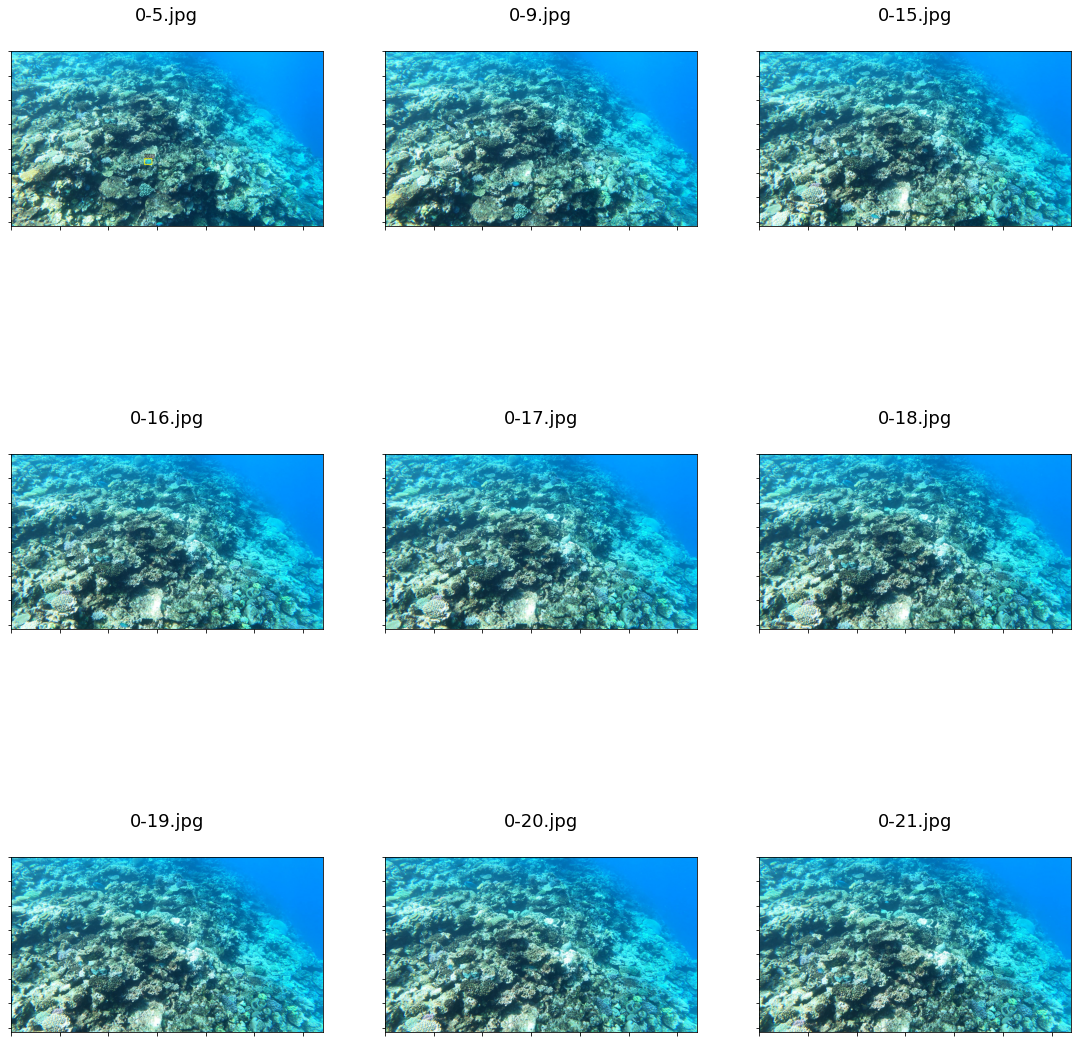

In [20]:
imgs_path = "../input/cots-mmdet-annotations-fold-0/val2017"
threshold = 0.45

fig, axes = plt.subplots(3,3, figsize=(19,21))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
axes = axes.ravel()

results_list = []

for idx, img_id in enumerate(imagepaths):
    img_path = os.path.join(imgs_path, img_id)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = inference_detector(model, img_path)
    results_filtered = result[0][result[0][:, 4]>threshold]
    bboxes = results_filtered[:, :4]
    scores = results_filtered[:, 4] 
    results_list.append(result[0])
    
    for box in bboxes:
        img = draw_bbox(img, list(np.int_(box)), "COTS",
                        (255, 243, 0))

    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(img_id, size=18, pad=30)
    axes[idx].set_xticklabels([])
    axes[idx].set_yticklabels([])

# Interactively Visualize & Analyze Output in Dashboard

In [21]:
run = wandb.init(project=wnb_project_name,
                 name=f'images-{model_name}-fold{fold}',
                 job_type='images')

class_id_to_label = {
    1: "pred_cots",
    2: "gt_cots"
}

wnb_images = []

for img_id, result in zip(imagepaths, results_list):
    
    bboxes = result[:, :4]
    scores = result[:, 4]
    ann_dict = {"predictions":{
                        "box_data":[],
                        "class_labels": class_id_to_label
                        },
                "ground_truth":{
                        "box_data":[],
                        "class_labels": class_id_to_label
                        }
                    }

    for box, score in zip(bboxes, scores):
        single_data = {
            # one box expressed in the default relative/fractional domain
            "position": {
                "minX": round(float(box[0])/1280, 3),
                "maxX": round(float(box[2])/1280, 3),
                "minY": round(float(box[1])/720, 3),
                "maxY": round(float(box[3])/720, 3),
            },
            "class_id" : 1,
            "box_caption": class_id_to_label[1],
            "scores" : {
                "confidence": float(score),
            }
        }
        ann_dict["predictions"]["box_data"].append(single_data)

    image_annotations = df_annotations.loc[df_annotations.image_id==img_id.strip('.jpg'), 'annotations'].values[0]

    if len(image_annotations) == 0:
        continue
    
    for bbox in image_annotations:
        minx, miny = round(float(bbox['x'])/1280, 3), round(float(bbox['y'])/720, 3)
        w, h = round(float(bbox['width'])/1280, 3), round(float(bbox['height'])/720, 3)
        maxx, maxy = minx + w, miny + h
        
        single_data = {
            # one box expressed in the default relative/fractional domain
            "position": {
                "minX": minx,
                "maxX": maxx,
                "minY": miny,
                "maxY": maxy,
            },
            "class_id" : 2,
            "box_caption": class_id_to_label[2],
            "scores" : {
                "confidence": 1.0,
            }
        }
        ann_dict["ground_truth"]["box_data"].append(single_data)

    image = cv2.imread(os.path.join(imgs_path, img_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    wnb_images.append(wandb.Image(image, boxes=ann_dict))
    
wandb.log({f'images-{model_name}-fold{fold}': wnb_images})

run.finish()
run

# Clean not necessary data

In [22]:
import shutil
shutil.rmtree('./mmdetection')